In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as torch_utils
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
manualSeed = 123
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  123


In [3]:
data_dir = "/kaggle/input/cartoon-faces-googles-cartoon-set"
model_save_path = "/kaggle/working/cartoons.pt"
animation_save_path = "/kaggle/working/animations.mp4"
training_plot_save_path = "/kaggle/working/train_plot.jpeg"

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_size = 64
lr = 0.0002
beta1 = 0.5
batch_size = 64
noise_dim = 100
workers = 2
num_epochs = 60
real_label = 1.
fake_label = 0.
# Monitor Progress
progress = list()
fixed_noise = torch.randn(batch_size, noise_dim, 1, 1, device=device)

In [5]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self) -> None:
        super(Discriminator, self).__init__()

        conv_1 = self.conv_block(3, 64)
        conv_2 = self.conv_block(64, 128)
        conv_3 = self.conv_block(128, 256)
        conv_4 = self.conv_block(256, 512)

        self.classifier = nn.Sequential(
            conv_1,
            conv_2,
            conv_3,
            conv_4,

            nn.Conv2d(512, 1, (5, 5), 2, 1),
            nn.Sigmoid()
        )
    
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
                                nn.Conv2d(in_channels, out_channels, (5, 5), 2, 2),
                                nn.BatchNorm2d(out_channels),
                                nn.LeakyReLU(0.2, inplace=True),
                            )

    def forward(self, x):
        return self.classifier(x)

In [6]:
# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        upsample_1 = self.upsample_block(100, 1024, 0)
        upsample_2 = self.upsample_block(1024, 512, 1)
        upsample_3 = self.upsample_block(512, 256, 1)
        upsample_4 = self.upsample_block(256, 128, 1)

        self.gen = nn.Sequential(
            upsample_1,
            upsample_2,
            upsample_3,
            upsample_4,
            
            nn.ConvTranspose2d(128, 3, (4, 4), 2, 1),
            nn.Tanh()
        )

    def upsample_block(self, in_channels, out_channels, padding):
        return nn.Sequential(
                                nn.ConvTranspose2d(in_channels, out_channels, (4, 4), 2, padding),
                                nn.BatchNorm2d(out_channels),
                                nn.ReLU(inplace = True),
                            )
    
    def forward(self, x):
        return self.gen(x)

In [7]:
# custom weights initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
dataset = datasets.ImageFolder(root=data_dir,
                               transform=transforms.Compose([
                                    transforms.Resize(image_size),
                                    transforms.CenterCrop(image_size),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ]))

dataloader = data.DataLoader(dataset, 
                             batch_size=batch_size,
                             shuffle=True, 
                             num_workers=workers)

In [9]:
disc_net = Discriminator()
gen_net = Generator()
disc_net.to(device)
gen_net.to(device)
disc_net.apply(weights_init)
gen_net.apply(weights_init)

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): ConvTranspose2d(128, 3, 

In [10]:
criterion = nn.BCELoss()

disc_optimizer = optim.Adam(disc_net.parameters(), lr=lr, betas=(beta1, 0.999))
gen_optimizer = optim.Adam(gen_net.parameters(), lr=lr, betas=(beta1, 0.999))

In [11]:
# Training Loop

# Lists to keep track of progress
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        
        # Training the discriminator
        # 1.a: Train Discriminator on Real Images
        # 1.b: Train Generator on Fake Images
        disc_net.zero_grad()

        real_images = data[0].to(device)
        num_images = real_images.size(0)
        label = torch.full((num_images,), real_label, dtype=torch.float, device=device)

        output = disc_net(real_images).view(-1)

        disc_err_real = criterion(output, label)
        disc_err_real.backward()


        noise = torch.randn(num_images, noise_dim, 1, 1, device=device)
        fake = gen_net(noise)
        label.fill_(fake_label)

        output = disc_net(fake.detach()).view(-1)

        disc_err_fake = criterion(output, label)
        disc_err_fake.backward()

        disc_err = disc_err_real + disc_err_fake
        disc_optimizer.step()

        # Training the Generator
        # Steps:
        # 1. Create Label Array all elements == 1
        # 2. Get Discriminator Predictions on Fake Images
        # 3. Calculate loss 
        gen_net.zero_grad()
        label.fill_(real_label) 
        output = disc_net(fake).view(-1)
        
        gen_err = criterion(output, label)
        gen_err.backward()

        gen_optimizer.step()

        # Training Update 
        if i % 50 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}]\tLoss_D: {disc_err.item()}\tLoss_G: {gen_err.item()}')

        # Tracking loss
        G_losses.append(gen_err.item())
        D_losses.append(disc_err.item())

        # Tracking Generator Progress
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen_net(fixed_noise).detach().cpu()
            progress.append(torch_utils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/60][0/1563]	Loss_D: 2.0860650539398193	Loss_G: 2.112046957015991
[0/60][50/1563]	Loss_D: 0.005429910961538553	Loss_G: 13.661696434020996
[0/60][100/1563]	Loss_D: 6.430035136872903e-05	Loss_G: 36.14997863769531
[0/60][150/1563]	Loss_D: 3.944365403185657e-07	Loss_G: 24.675037384033203
[0/60][200/1563]	Loss_D: 0.32843440771102905	Loss_G: 24.490144729614258
[0/60][250/1563]	Loss_D: 1.5878905057907104	Loss_G: 8.571352005004883
[0/60][300/1563]	Loss_D: 1.528282880783081	Loss_G: 1.5862338542938232
[0/60][350/1563]	Loss_D: 0.5463928580284119	Loss_G: 2.5443103313446045
[0/60][400/1563]	Loss_D: 0.31684941053390503	Loss_G: 3.623974323272705
[0/60][450/1563]	Loss_D: 1.0355470180511475	Loss_G: 1.4387433528900146
[0/60][500/1563]	Loss_D: 0.5906456112861633	Loss_G: 3.734964370727539
[0/60][550/1563]	Loss_D: 0.4802623987197876	Loss_G: 1.9846782684326172
[0/60][600/1563]	Loss_D: 1.7291263341903687	Loss_G: 1.0700829029083252
[0/60][650/1563]	Loss_D: 1.5511711835861206	Loss_G

In [12]:
# Save generator
torch.save(gen_net, model_save_path)

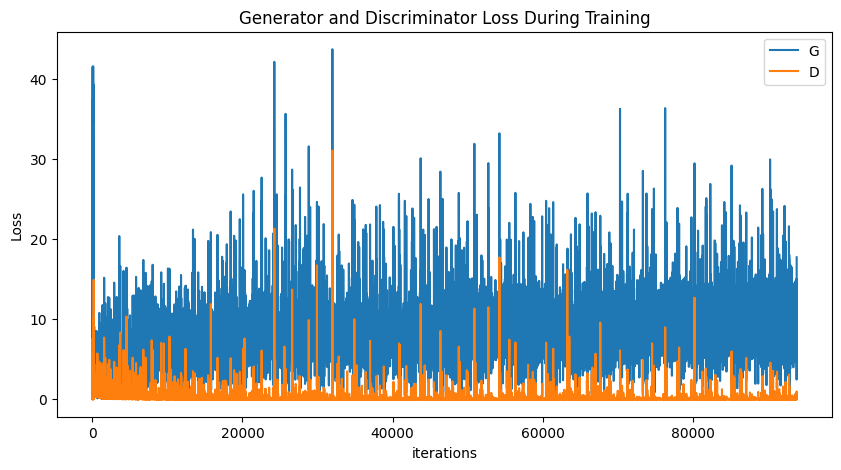

In [13]:
# Plot Training Graph
fig1 = plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(training_plot_save_path)
plt.show()

In [14]:
# Progress Animation
fig2 = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in progress]
anim = animation.ArtistAnimation(fig2, ims, interval=1000, repeat_delay=1000, blit=True)
writervideo = animation.FFMpegWriter(fps=60)
anim.save(animation_save_path, writer=writervideo)
plt.close()